In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# WebScraping

In [13]:
def scrape_review(base_url, num_pages):
    reviews = []

    for page in range(1, num_pages + 1):
        # Fetch the page
        url = f"{base_url}/page/{page}/"
        headers = {"accept" : "*/*", 
                   "accept-encoding" : "gzip, deflate, br, zstd" , 
                   "accept-language" : "en-US,en;q=0.9", 
                   "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36"}
        response = requests.get(url, headers=headers)
        
        soup = BeautifulSoup(response.content, "html.parser")

        review_containers = soup.find_all("div", class_="col-content")

        for container in review_containers:
            try:
                # Extract review details
                title = container.find("h2", class_="text_header").text.strip()
                rating = container.find("span", itemprop="ratingValue").text.strip()
                author = container.find("span", itemprop="name").text.strip()
                date_published = container.find("time", itemprop="datePublished").text.strip()
                review_text = container.find("div", class_="text_content").text.strip()

                # Extract additional info (Type of Traveller, Seat Type, etc.)
                additional_info = {}
                rows = container.find_all("tr") 
                for row in rows:
                    key = row.find("td", class_="review-rating-header").text.strip() if row.find("td", class_="review-rating-header") else None
                    value = row.find("td", class_="review-value").text.strip() if row.find("td", class_="review-value") else None
                    if key and value:
                        additional_info[key] = value

                # Append data to the reviews list
                reviews.append({
                    "title": title,
                    "rating": rating,
                    "author": author,
                    "date_published": date_published,
                    "review_text": review_text,
                    **additional_info  # Include additional info in the final dictionary
                })

            except AttributeError:
                # Skip review containers with missing data
                continue


    return pd.DataFrame(reviews)

In [5]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

In [7]:
df = scrape_review(base_url, num_pages = 390)

In [3]:
df.to_csv("skytrax_reviews.csv", index=False)
print("Data saved to skytrax_reviews.csv")

NameError: name 'df' is not defined

In [3]:
review = pd.read_csv("skytrax_reviews.csv")
review.head(5)

,title,rating,author,date_published,review_text,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Recommended
0,"""one of the best BA First flights I’ve had""",9,Robert Bone,3rd April 2025,Not Verified | LHR T5 BA Gold Wing worked wel...,A320,Solo Leisure,Economy Class,London Gatwick to Marrakech,February 2025,no
1,"""they still haven't replied""",1,E Vandoon,18th February 2025,✅ Trip Verified | I flew from Amsterdam to L...,A320,Business,Economy Class,London to Basel,January 2025,no
2,"""BA forced us to buy new tickets""",1,G Marton,4th January 2025,"✅ Trip Verified | We flew in November 2023, ...",A320,Solo Leisure,Economy Class,Marrakesh to London,August 2024,no
3,"""Terrible customer service""",1,S Warden,29th November 2024,✅ Trip Verified | I'm so fraustrated. My fli...,A320,Family Leisure,Economy Class,Gatwick to Florence,August 2024,no
4,“A very poor experience”,1,Kunal Purohit,5th November 2024,"✅ Trip Verified | I had visa issues, and hen...",Boeing 787-9,Business,Business Class,Mexico City to London Heathrow,October 2024,no


# Data Cleaning

In [80]:
review.columns

Index(['title', 'rating', 'author', 'date_published', 'review_text',
       'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Recommended',
       'Aircraft'],
      dtype='object')

In [82]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              391 non-null    object
 1   rating             391 non-null    int64 
 2   author             391 non-null    object
 3   date_published     391 non-null    object
 4   review_text        391 non-null    object
 5   Type Of Traveller  315 non-null    object
 6   Seat Type          391 non-null    object
 7   Route              314 non-null    object
 8   Date Flown         314 non-null    object
 9   Recommended        391 non-null    object
 10  Aircraft           315 non-null    object
dtypes: int64(1), object(10)
memory usage: 33.7+ KB


In [84]:
review.describe()

,rating
count,391.000000
mean,4.815857
std,3.288185
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,10.000000


In [5]:
#Handle missing values
review.isnull().sum()

title                 0
rating                0
author                0
date_published        0
review_text           0
Aircraft             74
Type Of Traveller    74
Seat Type             0
Route                74
Date Flown           75
Recommended           0
dtype: int64

In [21]:
review['Route'].nunique()

271

In [23]:
review['Type Of Traveller'].nunique()

4

In [7]:
review['Type Of Traveller'].value_counts().idxmax()

'Couple Leisure'

In [5]:
# Fill the missing value
review.fillna({
    'Route' : 'Unknown',
    'Date Flown' : 'Unknown',
    'Aircraft' : 'Unknown',
    'Type Of Traveller' : 'Couple Leisure'
}, inplace=True)

In [7]:
review.isnull().sum()

title                0
rating               0
author               0
date_published       0
review_text          0
Aircraft             0
Type Of Traveller    0
Seat Type            0
Route                0
Date Flown           0
Recommended          0
dtype: int64

In [9]:
#copying to another dataframe in case something goes wrong
df_review = review.copy()

In [11]:
def remove_ordinal_suffix(date_str):
    return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)

In [13]:
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]','',text)

In [15]:
#Covert to datetime
df_review['date_published'] = df_review['date_published'].apply(remove_ordinal_suffix)
df_review['date_published'] = pd.to_datetime(df_review['date_published'], format="%d %B %Y", errors='coerce')
df_review['Date Flown'] = pd.to_datetime(df_review['Date Flown'],format="%B %Y",errors='coerce')

In [23]:
df_review['review'] = df_review['review_text'].apply(remove_special_characters)

In [25]:
df_review['review'] = df_review['review'].str.lower()
df_review.head()

,title,rating,author,date_published,review_text,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Recommended,review
0,"""one of the best BA First flights I’ve had""",9,Robert Bone,2025-04-03,Not Verified | LHR T5 BA Gold Wing worked wel...,A320,Solo Leisure,Economy Class,London Gatwick to Marrakech,2025-02-01,no,not verified lhr t ba gold wing worked well ...
1,"""they still haven't replied""",1,E Vandoon,2025-02-18,✅ Trip Verified | I flew from Amsterdam to L...,A320,Business,Economy Class,London to Basel,2025-01-01,no,trip verified i flew from amsterdam to las...
2,"""BA forced us to buy new tickets""",1,G Marton,2025-01-04,"✅ Trip Verified | We flew in November 2023, ...",A320,Solo Leisure,Economy Class,Marrakesh to London,2024-08-01,no,trip verified we flew in november but it ...
3,"""Terrible customer service""",1,S Warden,2024-11-29,✅ Trip Verified | I'm so fraustrated. My fli...,A320,Family Leisure,Economy Class,Gatwick to Florence,2024-08-01,no,trip verified im so fraustrated my flight ...
4,“A very poor experience”,1,Kunal Purohit,2024-11-05,"✅ Trip Verified | I had visa issues, and hen...",Boeing 787-9,Business,Business Class,Mexico City to London Heathrow,2024-10-01,no,trip verified i had visa issues and hence ...


In [27]:
df_review.drop('review_text', inplace = True, axis = 1)

In [29]:
df_review['title'] = df_review['title'].apply(lambda x: x.lower()).str.strip('"')

In [31]:
df_review.head()

,title,rating,author,date_published,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Recommended,review
0,one of the best ba first flights i’ve had,9,Robert Bone,2025-04-03,A320,Solo Leisure,Economy Class,London Gatwick to Marrakech,2025-02-01,no,not verified lhr t ba gold wing worked well ...
1,they still haven't replied,1,E Vandoon,2025-02-18,A320,Business,Economy Class,London to Basel,2025-01-01,no,trip verified i flew from amsterdam to las...
2,ba forced us to buy new tickets,1,G Marton,2025-01-04,A320,Solo Leisure,Economy Class,Marrakesh to London,2024-08-01,no,trip verified we flew in november but it ...
3,terrible customer service,1,S Warden,2024-11-29,A320,Family Leisure,Economy Class,Gatwick to Florence,2024-08-01,no,trip verified im so fraustrated my flight ...
4,“a very poor experience”,1,Kunal Purohit,2024-11-05,Boeing 787-9,Business,Business Class,Mexico City to London Heathrow,2024-10-01,no,trip verified i had visa issues and hence ...


In [33]:
df_review.duplicated().sum()

0

# Sentiment analysis

In [35]:
import nltk
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [36]:
def pol(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment 

In [39]:
df_review['sentiment_score'] = df_review['review'].apply(pol)

In [41]:
df_review['sentiment_category'] = pd.cut(df_review['sentiment_score'], bins = [-1, -0.01, 0.01, 1], labels = ['Negative', 'Neutral','Positive'])

In [43]:
print(df_review['sentiment_category'].value_counts(normalize=True) * 100)

sentiment_category
Positive    65.384615
Negative    28.461538
Neutral      6.153846
Name: proportion, dtype: float64


# Word Cloud

In [45]:
df_review['tokenized_words'] = df_review['review'].apply(word_tokenize)

lemmatizer = WordNetLemmatizer()
df_review['lem_words'] = df_review['tokenized_words'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

In [46]:
stop_words= set(stopwords.words('english'))

In [47]:
df_review['lem_words'] = df_review['lem_words'].apply(lambda x: [word for word in x if word not in stop_words])

In [48]:
df_review['lem_words'] = ' '.join([' '.join(words) for words in df_review['lem_words']])

In [53]:
positive_reviews = " ".join(df_review.loc[df_review['sentiment_category'] == 'Positive', 'lem_words'])
negative_reviews = " ".join(df_review.loc[df_review['sentiment_category'] == 'Negative', 'lem_words'])

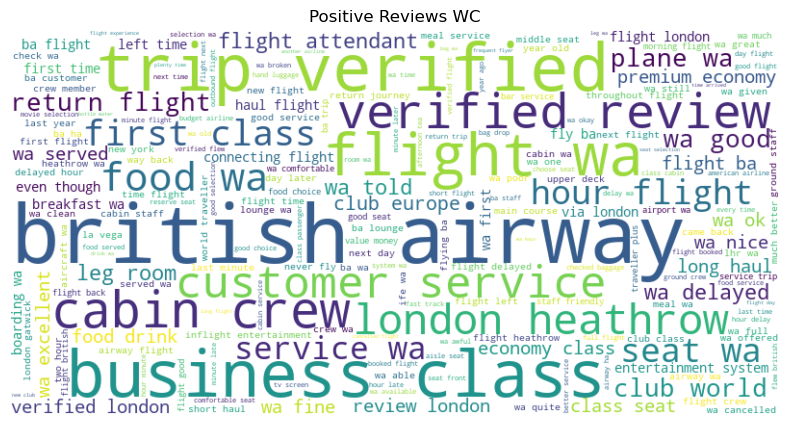

In [55]:
pos_WC = WordCloud(width = 800, height =400, background_color = 'white').generate(positive_reviews)

plt.figure(figsize = (10,5))
plt.imshow(pos_WC, interpolation = 'bilinear')
plt.axis('off')
plt.title('Positive Reviews WC')
plt.show()

In [ ]:
neg_WC = WordCloud(width = 800, height =400, background_color = 'white').generate(negative_reviews)

plt.figure(figsize = (10,5))
plt.imshow(neg_WC, interpolation = 'bilinear')
plt.title('Negative Reviews WC')
plt.axis('off')
plt.show()

# Topic Modelling

In [181]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [178]:
vectorizer = CountVectorizer()
text_matrix = vectorizer.fit_transform(df_review['lem_words'])

In [193]:
lda_model =  LatentDirichletAllocation(n_components = 2, random_state = 42)
lda_model.fit(text_matrix)

LatentDirichletAllocation(n_components=2, random_state=42)

In [195]:
for idx, topic in enumerate(lda_model.components_):
    print(f"topic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

topic 1:
['would', 'british', 'unknown', 'crew', 'time', 'service', 'seat', 'ba', 'flight', 'wa']
topic 2:
['unknown', 'class', 'time', 'hour', 'london', 'service', 'seat', 'ba', 'flight', 'wa']
